In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]
date_id                             0
D1                              

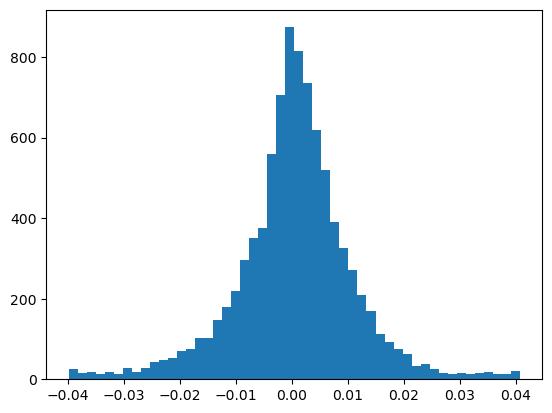

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Quick check
print(train.head())
print(train.isnull().sum())

# Target distributions
plt.hist(train['forward_returns'], bins=50)
plt.show()

In [5]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/2998219412.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/2998219412.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


In [6]:
lag_features = ['forward_returns'] + [c for c in train.columns if c.startswith(('M','E','I','P','V','S','MOM'))]

for feature in lag_features:
    for lag in range(1,6):
        train[f'{feature}_lag{lag}'] = train[feature].shift(lag)


/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/306653367.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'{feature}_lag{lag}'] = train[feature].shift(lag)
/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/306653367.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'{feature}_lag{lag}'] = train[feature].shift(lag)
/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/306653367.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [7]:
for feature in lag_features:
    train[f'{feature}_roll5'] = train[feature].rolling(5).mean()
    train[f'{feature}_roll5_std'] = train[feature].rolling(5).std()


/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/1897401805.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'{feature}_roll5'] = train[feature].rolling(5).mean()
/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/1897401805.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'{feature}_roll5_std'] = train[feature].rolling(5).std()
/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/1897401805.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [8]:
train = train.dropna()

In [9]:
X = train.drop(columns=['forward_returns', 'risk_free_rate', 'market_forward_excess_returns', 'date_id'])
y = train['forward_returns']

tscv = TimeSeriesSplit(n_splits=5)

In [12]:
import lightgbm as lgb

models = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        params={
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.01,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'seed': 42
        },
        train_set=lgb_train,
        num_boost_round=5000,
        valid_sets=[lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
    )
    
    models.append(model)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74584
[LightGBM] [Info] Number of data points in the train set: 342, number of used features: 692
[LightGBM] [Info] Start training from score 0.000274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [14]:
# Use the same lag and rolling feature transformations
lag_features = ['forward_returns'] + [c for c in train.columns if c.startswith(('M','E','I','P','V','S','MOM'))]

for feature in lag_features:
    for lag in range(1,6):
        if feature in test.columns:
            test[f'{feature}_lag{lag}'] = test[feature].shift(lag)
            
for feature in lag_features:
    if feature in test.columns:
        test[f'{feature}_roll5'] = test[feature].rolling(5).mean()
        test[f'{feature}_roll5_std'] = test[feature].rolling(5).std()

# Drop rows with NaNs in test after lag/rolling
X_test = test.drop(columns=['date_id', 'is_scored', 'lagged_forward_returns', 'lagged_risk_free_rate', 'lagged_market_forward_excess_returns']).dropna()


/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/3205274998.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[f'{feature}_lag{lag}'] = test[feature].shift(lag)
/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/3205274998.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[f'{feature}_lag{lag}'] = test[feature].shift(lag)
/var/folders/4_/4jj2bskn0rq35v92whxd37840000gn/T/ipykernel_48562/3205274998.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [16]:
X_train_cols = X.columns  # columns from training
X_test = X_test.reindex(columns=X_train_cols, fill_value=0)  # add missing columns with 0

preds = np.mean([model.predict(X_test) for model in models], axis=0)

In [17]:
# Simple linear mapping with clipping
alloc = np.clip(1 + 10 * preds, 0, 2)  # scale predicted returns

# Optional: smooth allocations
alloc = pd.Series(alloc).rolling(3, min_periods=1).mean().values


In [18]:
submission = pd.DataFrame({
    'date_id': test['date_id'],
    'allocation': alloc
})

submission.to_csv('submission.csv', index=False)

In [19]:
portfolio_returns = submission['allocation'] * test['lagged_forward_returns']
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
print('Backtested Sharpe Ratio:', sharpe_ratio)

Backtested Sharpe Ratio: 4.927509686143685
